251と同様

回帰

谷口特徴量追加

## 必要なライブラリのimport

In [1]:
import warnings
import time
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [2]:
# データの読み込み
path_train = '../../../../data/extornal/train_processed_clv&churn.csv'
train = pd.read_csv(path_train)

# 目的変数と説明変数の作成
target = train['target']
del train['target']

In [3]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id']]
categorical_feats = []
#['feature_1','feature_2', 'feature_3',]
# 'hist_merchant_category_mode','hist_city_mode','hist_state_mode','hist_category_1_mod','hist_category_2_mod','hist_category_3_mod',
# 'total_merchant_category_mode','total_city_mode','total_state_mode','total_category_1_mod','total_category_2_mod','total_category_3_mod',
# 'new_merchant_category_mode','new_city_mode','new_state_mode','new_category_1_mod','new_category_2_mod','new_category_3_mod']

In [4]:
train

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,quarter,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_mean,feature_max,feature_min,feature_var,history_transactions_count,history_category_1_sum,history_category_1_mean,history_category_2_1.0_mean,history_category_2_2.0_mean,history_category_2_3.0_mean,history_category_2_4.0_mean,history_category_2_5.0_mean,history_category_3_1.0_mean,history_category_3_2.0_mean,history_category_3_3.0_mean,history_merchant_id_nunique,history_merchant_category_id_nunique,history_state_id_nunique,history_city_id_nunique,history_subsector_id_nunique,history_purchase_amount_sum,history_purchase_amount_mean,history_purchase_amount_max,history_purchase_amount_min,history_purchase_amount_std,history_installments_sum,history_installments_mean,history_installments_max,history_installments_min,history_installments_std,history_purchase_month_mean,history_purchase_month_max,history_purchase_month_min,history_purchase_month_std,history_purchase_date_ptp,history_purchase_date_min,history_purchase_date_max,history_month_lag_mean,history_month_lag_max,history_month_lag_min,history_month_lag_std,history_month_diff_mean,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_1.0_mean,auth_category_3_2.0_mean,auth_category_3_3.0_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_1.0_mean,new_category_3_2.0_mean,new_category_3_3.0_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum_x,new_installments_mean_x,new_installments_max_x,new_installments_min_x,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean_x,new_month_lag_max_x,new_month_lag_min_x,new_month_lag_std,new_month_diff_mean,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,authorized_flag_mean,category_1_purchase_amount_mean,category_1_purchase_amount_min,category_1_purchase_amount_max,category_1_purchase_amount_std,installments_purchase_amount_mean,installments_purchase_amount_min,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,c

In [5]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149,
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [8]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(train))
predictions = np.zeros(len(target))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    #clf = lgb.train(param, trn_data)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/lgb_52/', exist_ok=True)
    with open(f'../src/models/lgb_52/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.70968
[200]	valid_0's rmse: 3.66119
[300]	valid_0's rmse: 3.63746
[400]	valid_0's rmse: 3.62536
[500]	valid_0's rmse: 3.61858
[600]	valid_0's rmse: 3.61417
[700]	valid_0's rmse: 3.61099
[800]	valid_0's rmse: 3.60881
[900]	valid_0's rmse: 3.60772
[1000]	valid_0's rmse: 3.60701
[1100]	valid_0's rmse: 3.60616
[1200]	valid_0's rmse: 3.60557
[1300]	valid_0's rmse: 3.60528
[1400]	valid_0's rmse: 3.60511
[1500]	valid_0's rmse: 3.60511
[1600]	valid_0's rmse: 3.60488
[1700]	valid_0's rmse: 3.60451
[1800]	valid_0's rmse: 3.60451
[1900]	valid_0's rmse: 3.60435
[2000]	valid_0's rmse: 3.60435
[2100]	valid_0's rmse: 3.60435
[2200]	valid_0's rmse: 3.60448
[2300]	valid_0's rmse: 3.60466
Early stopping, best iteration is:
[2133]	valid_0's rmse: 3.60421
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.74324
[200]	valid_0's rmse: 3.69358
[300]	valid_0's rmse: 3.6695

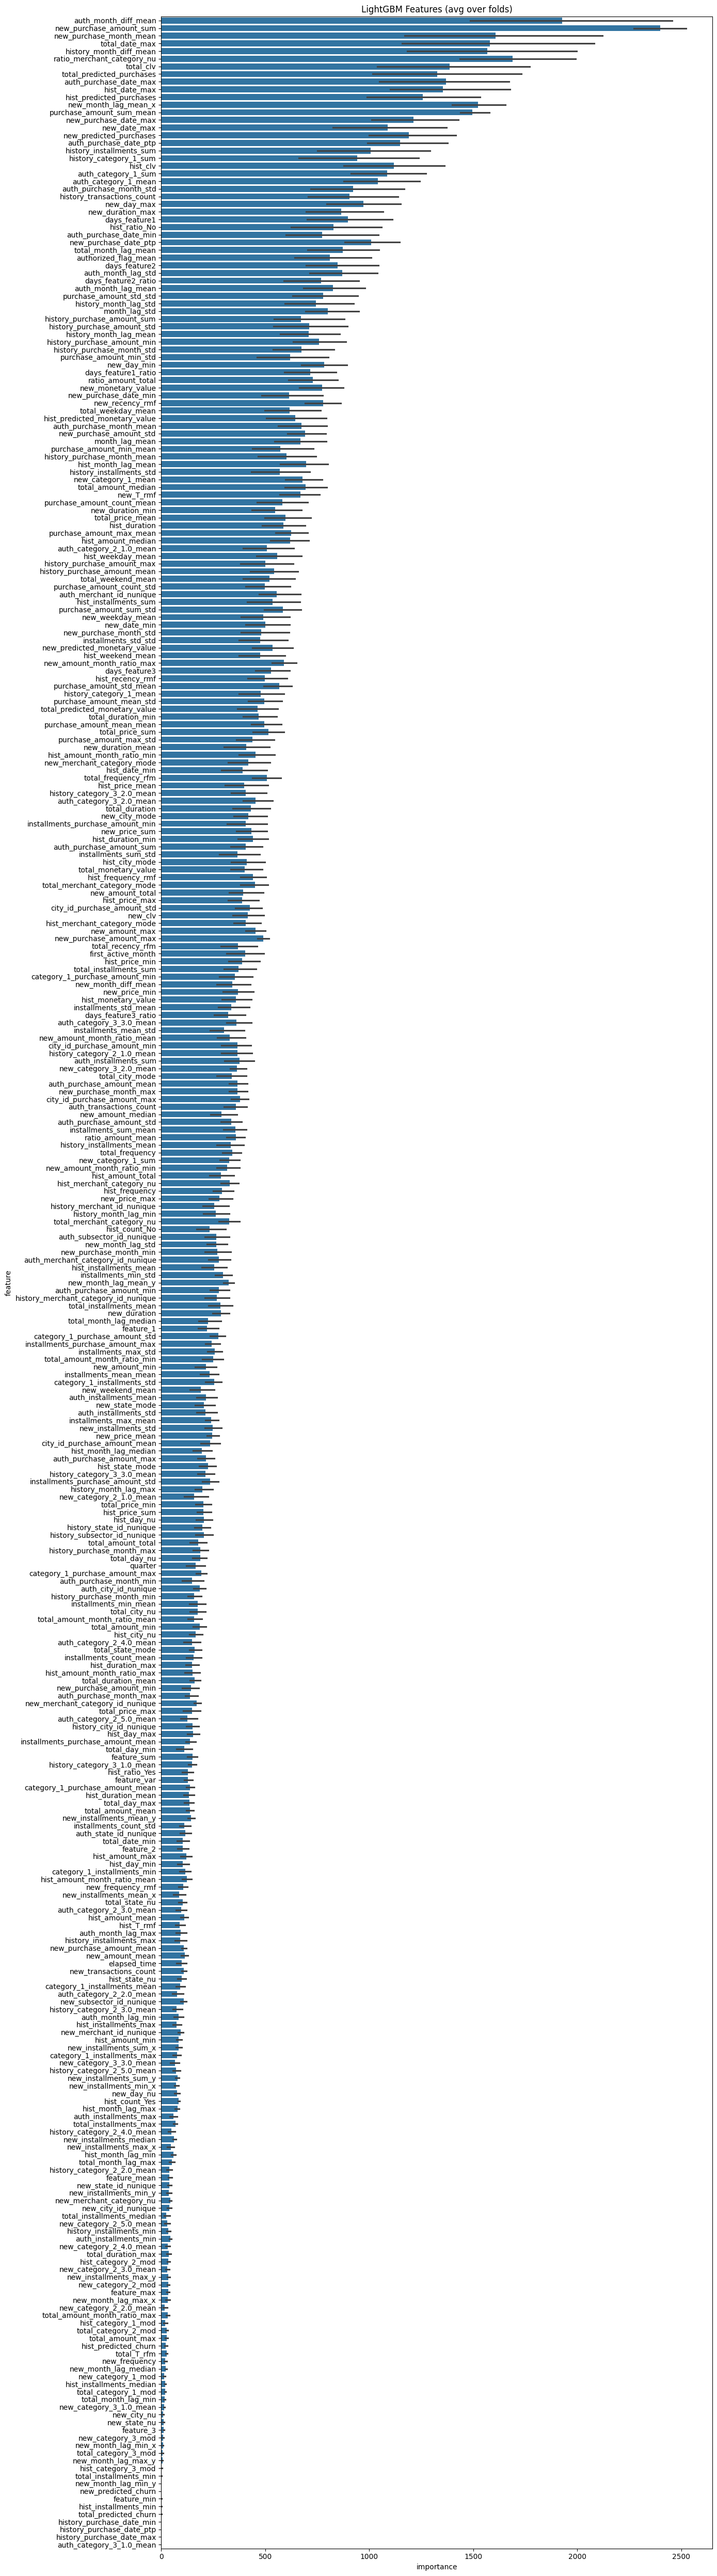

In [7]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+0

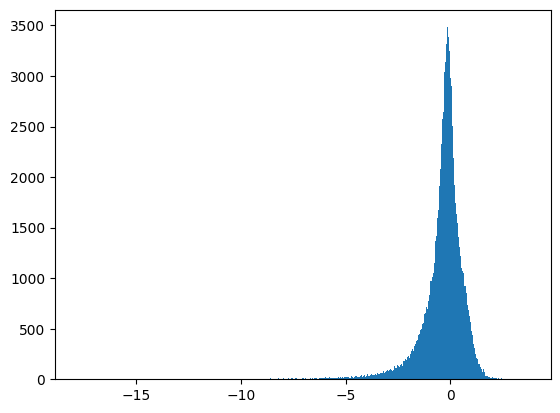

In [8]:
plt.hist(oof[oof<2**8],bins=1000)

In [10]:
feature = feature_importance_df.groupby('feature',as_index=False).importance.mean().sort_values('importance').reset_index(drop=True)
feature

,feature,importance
0,history_purchase_date_ptp,0.0
1,auth_category_3_1.0_mean,0.0
2,history_purchase_date_max,0.0
3,history_purchase_date_min,0.0
4,total_predicted_churn,0.2
...,...,...
326,total_date_max,1579.6
327,new_purchase_month_mean,1608.2
328,ratio_merchant_category_nu,1689.6
329,auth_month_diff_mean,1927.8


In [ ]:
feature.describe()

,importance
count,331.000000
mean,368.248338
std,367.191068
min,0.000000
25%,103.600000
50%,265.600000
75%,500.000000
max,2397.600000


In [11]:
feature.to_csv('../../../../data/processed/features_52_all.csv', index=False)

In [12]:
feature.query('importance>=100').head(20)

,feature,importance
80,feature_2,102.6
81,total_state_nu,102.6
82,hist_day_min,103.2
83,total_date_min,104.0
84,new_frequency_rmf,104.8
85,new_purchase_amount_mean,107.6
86,new_transactions_count,108.0
87,new_subsector_id_nunique,108.6
88,total_day_min,110.2
89,installments_count_std,110.4


In [13]:
feature.query('importance>=105').to_csv('../../../../data/processed/features_52.csv', index=False)
